In [1]:
import GOES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import gc
from scipy import ndimage as nd

# Get EBT Data
Generated in data_acquisition.ipynb

In [2]:
data_raw = pd.read_csv('/VOLUMES/SEAGATE/capsnet/EBT_processed.csv', parse_dates=['date'])
data_raw.atcf = data_raw.atcf.astype(int)

In [7]:
# Filter down to years of interest:
MIN_YEAR = 2000
BASIN = 'AL'
data = data_raw[(data_raw.date.dt.year >= MIN_YEAR) & (data_raw.basin == BASIN)]

In [8]:
# Do operations so that you only keep data between first time a storm hit 35 kt, until the last time it goes below 35 kt, or until it goes extratropical (whichever comes first)
time_limits = data[(data.wind >= 35) & (data.type != 'E')].groupby('ID').agg({'date': ['min', 'max']})
time_limits.columns = time_limits.columns.droplevel()

ids = pd.unique(data[(data.wind >= 35) & (data.type != 'E')].ID)
data_filtered_list = []
for id in ids:
    min_time = time_limits.loc[id]['min']
    max_time = time_limits.loc[id]['max']
    data_filtered_list.append(data[(data.ID == id) & (data.date >= min_time) & (data.date <= max_time)])
data_filtered = pd.concat(data_filtered_list)

data_to_merge = data_filtered[['ID', 'date', 'wind', 'eye_diam', 'rmw', 'atcf', 'lat', 'lon', 
                               'pressure_min', 'distance', 'type', 'pressure_outer', 'radius_outer']].reset_index(drop = True)

In [9]:
# Clean up
del data_raw, data, data_filtered_list, data_filtered, ids, id, max_time, min_time
gc.collect()

0

Working code:

<AxesSubplot:>

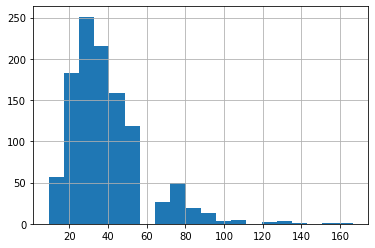

In [7]:
data_to_merge[data_to_merge.eye_diam != -99].eye_diam.hist(bins = 20)

In [ ]:
a = get_training_images('AL032000', '/Volumes/SEAGATE/GOES/', data_to_merge, time_limits, tc_data_only=True)
a[75:125]

# Get GOES Images

In [11]:
def get_training_images(id, filepath, tc_data_to_merge, time_limits, tc_data_only = False):
    """
    Get the set of nicely formatted and pre-processed images for a specific storm.

    Arguments:
        - id (str): Storm ID.
        - filepath (str): Filepath pointing to the directory where GOES xr.datasets 
            are stored.
        - tc_data_to_merge (pd.DataFrame): Dataframe containing synopic-time dates,
             wind speed, and ID for this storm (or all storms).
        - time_limits (pd.DataFrame): Dataframe containing the time bounds that 
            we want to return images within. Should have index as storm ID, and
            columns 'min' and 'max' giving pd.datetime objects in each column.
    
    Returns:

    """
    goes = GOES.Stamp.from_filename(filepath + id +'-half-hr-1000.nc')

    goes_times = pd.DataFrame({
        'ID': id,
        'date': pd.to_datetime(goes.data.time.values).round('min')
    })

    min_time = time_limits.loc[id]['min']
    max_time = time_limits.loc[id]['max']
    time_indices = np.squeeze(np.argwhere(((goes_times.date >= min_time) & (goes_times.date <= max_time)).to_numpy()))
    time_indices = np.sort(time_indices)

    goes_times_filtered = goes_times.iloc[time_indices]
    goes_times_filtered['time_idx'] = time_indices

    merged = goes_times_filtered.merge(tc_data_to_merge, on = ['ID', 'date'], how = 'left')
    merged['wind'] = merged.wind.interpolate() # Interpolate wind to non-synoptic times
    merged['eye'], merged['synoptic'] = eye_presence_close(merged) 
    merged['eye_10'], _ = eye_presence_close(merged, threshold=10.0)
    merged['eye_20'], _ = eye_presence_close(merged, threshold=20.0)
    merged['eye_30'], _ = eye_presence_close(merged, threshold=30.0)
    merged[['category', 'category_num']] = merged.apply(storm_category, axis = 1, result_type='expand')
    merged['atcf'] = np.where(np.isnan(merged.atcf), -99, merged.atcf)

    if tc_data_only:
        merged['nan_frac'] = np.repeat(-99.9, len(merged))
        return merged

    images = []
    nan_fracs = []

    for time_idx in merged.time_idx:
        image, nan_frac = stamp_at_time(goes, time_idx, 400)
        filled_image = sequential_fill(image)
        reshaped_image = reshape(filled_image, size = (200, 200))

        images.append(reshaped_image)
        nan_fracs.append(nan_frac)
        
    images = np.array(images)
    merged['nan_frac'] = np.array(nan_fracs)
    

    return (images, merged)


def eye_presence_close(data, threshold = 0.0):
    n = len(data)
    eye_temp = np.array(data.eye_diam >= threshold, dtype = 'float32')

    eye_temp[np.logical_or(np.isnan(data.eye_diam), (data.eye_diam < threshold) & (data.eye_diam >= 0))] = np.nan

    eye_idx = np.argwhere(eye_temp == 1).flatten().astype(int)
    eye_idx_tot = []
    for idx in eye_idx:
        eye_idx_tot.extend([idx + ii for ii in [-2, -1, 0, 1, 2]])
    eye_idx_tot = np.unique(np.array(eye_idx_tot)).astype(int)
    eye_idx_tot = eye_idx_tot[np.logical_and(eye_idx_tot >= 0, eye_idx_tot < n)]

    no_eye_idx = np.argwhere(eye_temp == 0).flatten().astype(int)
    no_eye_idx_tot = []
    for idx in no_eye_idx:
        no_eye_idx_tot.append([idx + ii for ii in [-2, -1, 0, 1, 2]])
    no_eye_idx_tot = np.unique(np.concatenate(no_eye_idx_tot)).astype(int)
    no_eye_idx_tot = no_eye_idx_tot[np.logical_and(no_eye_idx_tot >= 0, no_eye_idx_tot < n)]

    eye_final = np.repeat(-99, len(eye_temp)).astype('int8')
    eye_final[eye_idx_tot] = 1
    eye_final[no_eye_idx_tot] = 0
    
    eye_synoptic = np.repeat(0, len(eye_temp)).astype('int8')
    eye_synoptic[np.argwhere(~np.isnan(data.eye_diam).to_numpy()).flatten()] = 1

    return (eye_final, eye_synoptic)


def eye_presence(data):
    assert 'eye_diam' in data, 'eye_diam variable must be a column in data'
    
    eye_temp = pd.Series(data.eye_diam > 0, dtype = 'float32')
    eye_temp[np.isnan(data.eye_diam)] = np.nan
    eye_out = eye_temp.interpolate()
    eye_out_final = np.where(eye_out > 0.5, 1, 0)
    eye_out_check = np.where((eye_out != 0.0) & (eye_out != 1.0), 1, 0)

    return (eye_out_final, eye_out_check)

def storm_category(row):
    if row['wind'] < 64: # Tropical Storm
        return ('TS', 0)
    if 64 <= row['wind'] < 96: # Cat 1 or 2 (hurricane: H)
        return ('H', 1)
    if 96 <= row['wind']: # Cat 3, 4, 5 (major hurricane: MH)
        return ('MH', 2)

def stamp_at_time(goes_dataset, time_idx, radius):
    """
    Given a full xarray dataset representing GOES observations for a given storm
    in Trey's format, return a square stamp with specified radius at the specified
    time index. 

    Arguments:
        - goes_dataset (xr.dataset): As returned from e.g. GOES.Stamp.from_filename()
        - time_idx (int): Time index at which to return a stamp.
        - radius (float): Units of km. Must be <= 1000km.

    Returns:
        List of: [0] a np.ndarray containing the temperature stamp.
                 [1] the fraction of pixels in the stamp that are missing.
    """
    temp_full = goes_dataset.data.temperature[time_idx].values
    lat_center = goes_dataset.data.LATCENTER.values[time_idx]
    lon_center = goes_dataset.data.LONCENTER.values[time_idx]

    bounding_box = GOES.coord_from_distance(lat_center, lon_center, radius)

    lats = goes_dataset.data.lat.values + goes_dataset.data.LATSHIFT.values[time_idx]
    lons = goes_dataset.data.lon.values + goes_dataset.data.LONSHIFT.values[time_idx]

    lat_idx = np.squeeze(np.argwhere((lats < bounding_box['latHi']) & (lats > bounding_box['latLo'])))
    lon_idx = np.squeeze(np.argwhere((lons < bounding_box['lonHi']) & (lons > bounding_box['lonLo'])))

    temp_stamp = temp_full[(min(lat_idx) - 1):(max(lat_idx) + 2), (min(lon_idx) - 1):(max(lon_idx) + 2)]

    nan_frac = np.isnan(temp_stamp).sum()/(temp_stamp.shape[0] * temp_stamp.shape[1])

    return [temp_stamp, nan_frac]

def fill(data):
    """
    Replace the value of invalid 'data' cells by the value of the nearest valid data cell

    Arguments:
        data:    numpy array of any dimension

    Output: 
        Return a filled array. 
    """    
    invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)

    return data[tuple(ind)]

def sequential_fill(img):
    """
    Fill in missing pixels in a sattelite image.

    Step 1: Apply the cv2.inpaint method, which utilizes navier stokes equations
            to determine the best fill values. Experimentation shows that this 
            method leaves some pixels un-filled, but fills in the vast majority
            in a good looking way.

    Step 2: Utilize scipy.ndimage to fill the remaning missing pixels with the 
            value of its nearest neighbor pixel.

    Arguments:
        img (np.ndarray): A 2D numpy array representing sattelite imagery.
    """
    img_mask = np.where(np.isnan(img), 1, 0).astype('uint8') # Mask of missing pixels
    img_painted = cv2.inpaint(img, img_mask, 1, cv2.INPAINT_NS) # Step 1
    img_filled = fill(img_painted) # Step 2

    return img_filled

def reshape(img, size):
    return cv2.resize(img, size, interpolation = cv2.INTER_AREA)


In [9]:
GOES_fp = '/Volumes/SEAGATE/GOES/'

ids_to_load = pd.unique(data_to_merge.ID)

tc_images_list = []
tc_data_list = []

n = len(ids_to_load)
i = 1
for id in ids_to_load:
    if i % 20 == 0:
        print(f'Storm {i} / {n}')
    i += 1
    
    try:
        images, tc_data = get_training_images(id, GOES_fp, data_to_merge, time_limits)

        tc_images_list.append(images)
        tc_data_list.append(tc_data)
    except Exception as e:
        print(f'Error for storm {id}')
        print(e)



Error for storm AL062000
axis -1 is out of bounds for array of dimension 0
Storm 20 / 338
Storm 40 / 338
Storm 60 / 338
Storm 80 / 338
Storm 100 / 338
Error for storm AL312006
[Errno 2] No such file or directory: b'/Volumes/SEAGATE/GOES/AL312006-half-hr-1000.nc'
Storm 120 / 338
Storm 140 / 338
Storm 160 / 338
Storm 180 / 338
Storm 200 / 338
Storm 220 / 338
Storm 240 / 338
Storm 260 / 338
Error for storm AL102017
[Errno 2] No such file or directory: b'/Volumes/SEAGATE/GOES/AL102017-half-hr-1000.nc'
Error for storm AL182017
axis -1 is out of bounds for array of dimension 0
Storm 280 / 338
Storm 300 / 338
Error for storm AL112019
axis -1 is out of bounds for array of dimension 0
Storm 320 / 338


In [ ]:
tc_images = np.concatenate(tc_images_list, axis = 0)

In [9]:
np.save(file = '/Volumes/SEAGATE/capsnet/satellite_images.npy', arr = tc_images)

In [10]:
tc_data = pd.concat(tc_data_list)

In [11]:
tc_data.to_csv('/Volumes/SEAGATE/capsnet/tc_data.csv', index = False)

In [12]:
tc_data

,ID,date,time_idx,wind,eye_diam,rmw,atcf,lat,lon,pressure_min,...,pressure_outer,radius_outer,eye,synoptic,eye_10,eye_20,eye_30,category,category_num,nan_frac
0,AL032000,2000-08-04 06:00:00,24,35.000000,-99.0,55.56,False,12.0,22.3,1004.0,...,1014.0,444.48,0,1,0,0,0,TS,0,0.000000
1,AL032000,2000-08-04 06:30:00,25,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,TS,0,0.000025
2,AL032000,2000-08-04 07:00:00,26,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,TS,0,0.000000
3,AL032000,2000-08-04 07:30:00,27,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-99,0,-99,-99,-99,TS,0,0.000000
4,AL032000,2000-08-04 08:00:00,28,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-99,0,-99,-99,-99,TS,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,AL312020,2020-11-18 04:00:00,272,36.666667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-99,0,-99,-99,-99,TS,0,0.000000
213,AL312020,2020-11-18 04:30:00,273,36.250000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-99,0,-99,-99,-99,TS,0,0.000000
214,AL312020,2020-11-18 05:00:00,274,35.833333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,TS,0,0.000000
215,AL312020,2020-11-18 05:30:00,275,35.416667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,TS,0,0.000000


## Some post-processing

In [10]:
tc_data = pd.read_csv('/Volumes/SEAGATE/capsnet/tc_data.csv', parse_dates=['date'])

Filter images that had more than 7.5% missing pixels (total heuristic based on looking at a few images). This will remove ~ 2,000 out of the 78,000 images so it's not a huge loss of data.

Also filter down to only observations where the wind is at least 35 kt. This will remove ~ 4500 observations, but we want only the more well-formed systems.

In [13]:
NAN_FRAC_CUTOFF = 0.075
idx_to_delete = np.argwhere(((tc_data.nan_frac > NAN_FRAC_CUTOFF) | (tc_data.wind < 35)).to_numpy()).flatten()

tc_data_clean = tc_data[(tc_data.nan_frac <= NAN_FRAC_CUTOFF) & (tc_data.wind >= 35)]

In [14]:
tc_data_clean.to_csv('/Volumes/SEAGATE/capsnet/tc_data_clean.csv', index = False)

In [111]:
#tc_images = np.load('/Volumes/SEAGATE/capsnet/satellite_images.npy')
tc_images_clean = np.delete(tc_images, idx_to_delete, axis = 0)

In [11]:
np.save(file = '/Volumes/SEAGATE/capsnet/satellite_images_clean.npy', arr = tc_images_clean)

In [15]:
len(tc_data_clean)

71595

In [ ]:
len(tc_images_clean)

## Create subset of tc and image data to play with for development purposes

In [2]:
tc_data_clean = pd.read_csv('/Volumes/SEAGATE/capsnet/tc_data_clean.csv', parse_dates=['date'])

/Users/galen/anaconda3/envs/tc-rmw/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
tc_images_clean = np.load('/Volumes/SEAGATE/capsnet/satellite_images_clean.npy')

In [16]:
SAMPLE_N = 2000
np.random.seed(42)

n = len(tc_data_clean)

rand_idx = np.sort(np.random.choice(n, size=SAMPLE_N, replace=False))

In [17]:
tc_data_dev = tc_data_clean.iloc[rand_idx]
tc_data_dev.to_csv('/Volumes/SEAGATE/capsnet/tc_data_dev.csv', index = False)

In [116]:
tc_images_dev = tc_images_clean[rand_idx]
np.save(file = '/Volumes/SEAGATE/capsnet/satellite_images_dev.npy', arr = tc_images_dev)

Checking the eye labels

In [36]:
data[data.rmw >= 0]

,ID,date,time_idx,wind,eye_diam,rmw,lat,lon,pressure_min,distance,...,eye,synoptic,eye_10,eye_15,eye_20,eye_25,eye_30,category,category_num,nan_frac
0,AL032000,2000-08-04 06:00:00,24,35.0,-99.0,30.0,12.0,22.3,1004.0,587.0,...,0,1,0,0,0,0,0,TS,0,0.000000
11,AL032000,2000-08-04 12:00:00,36,35.0,-99.0,30.0,12.3,23.8,1003.0,721.0,...,0,1,0,0,0,0,0,TS,0,0.002000
23,AL032000,2000-08-04 18:00:00,48,40.0,-99.0,30.0,12.7,25.2,1002.0,850.0,...,0,1,0,0,0,0,0,TS,0,0.005805
35,AL032000,2000-08-05 00:00:00,60,40.0,-99.0,30.0,13.2,26.7,1001.0,995.0,...,0,1,0,0,0,0,0,TS,0,0.008034
47,AL032000,2000-08-05 06:00:00,72,45.0,-99.0,30.0,13.7,28.2,1000.0,1147.0,...,0,1,0,0,0,0,0,TS,0,0.020784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71546,AL312020,2020-11-17 06:00:00,228,110.0,-99.0,20.0,13.7,83.8,935.0,-22.0,...,0,1,0,0,0,0,0,MH,2,0.000000
71558,AL312020,2020-11-17 12:00:00,240,75.0,-99.0,25.0,13.7,84.7,965.0,-119.0,...,0,1,0,0,0,0,0,H,1,0.000000
71570,AL312020,2020-11-17 18:00:00,252,55.0,-99.0,55.0,13.7,85.7,988.0,-225.0,...,0,1,0,0,0,0,0,TS,0,0.000000
71582,AL312020,2020-11-18 00:00:00,264,40.0,-99.0,120.0,13.8,86.7,1000.0,-162.0,...,0,1,0,0,0,0,0,TS,0,0.000000


In [3]:
data = pd.read_csv('/Volumes/SEAGATE/capsnet/tc_data_clean.csv', parse_dates=['date'])
imgs = np.load('/Volumes/SEAGATE/capsnet/satellite_images_clean.npy')

In [22]:
eye_idx = np.argwhere((data.eye_20.to_numpy() == 1) & (data.synoptic.to_numpy() == 1)).flatten()
no_eye_idx = np.argwhere(data.eye.to_numpy() == 0).flatten()
print(f'Num eyes: {eye_idx.shape[0]}')

Num eyes: 563


In [15]:
titles = {
    0: 'Eye',
    1: 'No Eye'
}

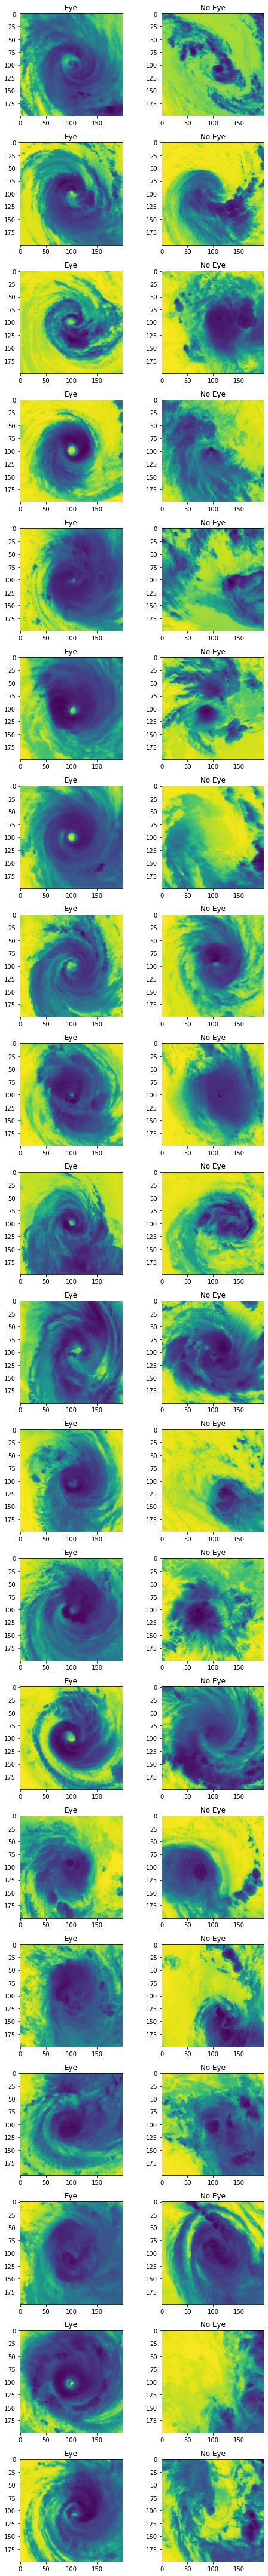

In [23]:
nplot = 20
randseed = 42

fig, axs = plt.subplots(nrows = nplot, ncols = 2, figsize = (7, 60))
np.random.seed(randseed)
indices = [np.random.choice(x, size = nplot, replace = False) for x in [eye_idx, no_eye_idx]]
indices = np.array(indices).T

for ii, ind in enumerate(indices):
    for jj, idx in enumerate(ind):
        axs[ii, jj].imshow(imgs[idx])
        axs[ii, jj].set_title(titles[jj])

plt.tight_layout()

Example visualization of the different missing data filling steps

Orig shape: (200, 270)


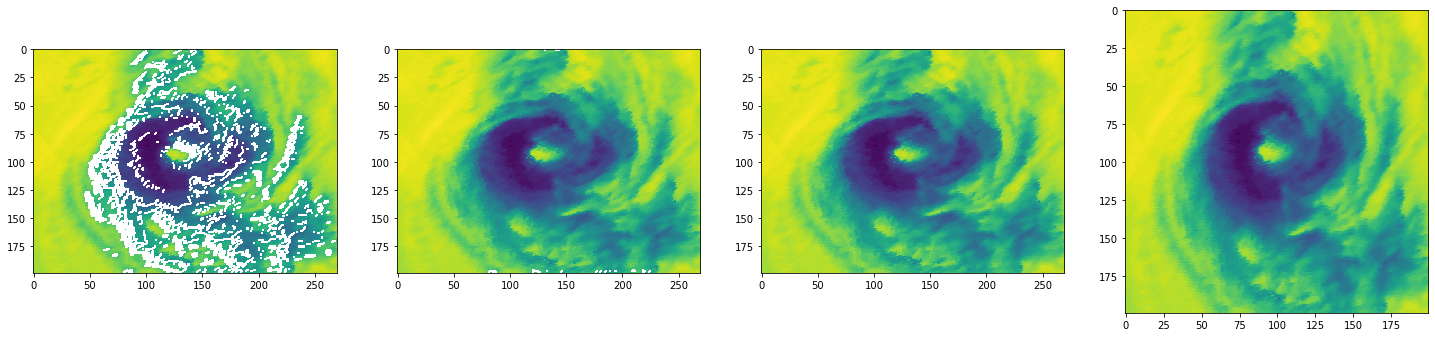

In [21]:
goes = GOES.Stamp.from_filename('/Volumes/SEAGATE/GOES/AL032000-half-hr-1000.nc')
tst, na_frac = stamp_at_time(goes, 886, 400)
tst_mask = np.where(np.isnan(tst), 1, 0).astype('uint8')
tst_paint = cv2.inpaint(tst, tst_mask, 1, cv2.INPAINT_NS)
tst_fill = fill(tst_paint)
print(f'Orig shape: {tst_fill.shape}')
tst_reshaped = cv2.resize(tst_fill, (200, 200), interpolation = cv2.INTER_AREA) # Reshape to 200x200, which is approx 4kmx4km resolution, since our stamps are 400km radius. So this reshape approximately matches the highest resolution satellite images we will get (near the equator).

fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize = (25, 20))
ax1.imshow(tst)
ax2.imshow(tst_paint)
ax3.imshow(tst_fill)
ax4.imshow(tst_reshaped)